# Automatic Reward Shaping from Confounded Offline Data
This notebook is based on our ICML 25 [paper](https://openreview.net/forum?id=Hu7hUjEMiW&referrer=%5BAuthor%20Console%5D(%2Fgroup%3Fid%3DICML.cc%2F2025%2FConference%2FAuthors%23your-submissions)).
Also see the Techical Report version [here](https://causalai.net/r123.pdf).

The task is to learn a potential function automatically from offline data to be used in Potential Based Reward Shaping (PBRS). The new reward function after reward shaping is defined to be,
$$
Y' = Y + \gamma\phi(s') - \phi(s)
$$
where $Y$ is the original reward signal and $Y'$ is the one after shaping. $\phi(\cdot)$ is the potential function we aim to learn automatically from offline datasets.

Intuitively, one can use the optimal state values as the potential function. And if the provided offline dataset is generated by a good enough policy, one can directly take the average cumulative return as the state value estimations. However, when the offline dataset is confounded or the data generating policy is sub-optimal, such naive estimations are highly biased and could mislead the policy training. See example 1&2 in the paper for more details.

In this work, we use causal bounds to estimate an upper bound on the optimal interventional
state values. Then, we take the estimated upper value bound as the potential function to train our online policy learner, Q-UCB.

## Environment Definition and Data Generation
In this notebook, we will replicate our example results in environment RobotWalk, corresponding to Example 1-3 in the paper.

In [1]:
import copy
import gymnasium as gym
from causal_gym.core import Task, PCH

GAMMA = 1 # discount
ALPHA = .1 # learning rate
EPS = .001 # error tolerance
LENGTH = 10 # hallway length
ACTION_DIM = 2 # action dimention
PUT = [.5, .5] # noise distribution

# First let's get a brief overview of the environment
env_name = 'causal_gym/RobotWalk-v0'
# Initialize the environment
env: PCH = gym.make(
    env_name, 
    task=Task(learning_regime='cool'),
    length=LENGTH,
    timelimit=30,
    put=PUT
)

# The goal of the agent is to reach the end of the hallway
# before the time is up.
state, info = env.reset()
print(f"Current agent location: {state[0]}")
print(f"Current stability status: {state[1]}")

Current agent location: 0
Current stability status: 1


In [2]:
import json
import numpy as np
# Calculate state values of perfect interventional policy
# By default, the last state is 0 value
true_value = np.zeros([LENGTH+1, 2])
true_qvalue = np.zeros([LENGTH+1, 2, ACTION_DIM])

prev_true_value = np.zeros([LENGTH+1, 2])
prev_true_qvalue = np.zeros([LENGTH+1, 2, ACTION_DIM])

state, info = env.reset()
# Calculated by value iteration
while True:
    for loc, stable in np.ndindex(LENGTH, 2):
        for x in range(ACTION_DIM):
            weighted_next_value = 0
            for ut, put in zip([0, 1], env.env.stable_u_dist):
                env.env.ut = ut
                env.env.current_location = loc
                env.env.is_stable = stable
                sp, reward, _, _, info = env.do(lambda m: x)
                weighted_next_value += put * (reward + GAMMA * prev_true_value[sp[0], sp[1]])
            true_qvalue[loc, stable, x] = weighted_next_value
        true_value[loc, stable] = max(true_qvalue[loc, stable, :])
    if np.all(abs(true_qvalue - prev_true_qvalue) < EPS):
        break
    else:
        prev_true_qvalue = copy.copy(true_qvalue)
        prev_true_value = copy.copy(true_value)

print("Optiaml state values")
print(np.round(true_value, decimals=5))
print("Optimal Q-value for the first two states")
print(np.round(true_qvalue[0:2,], decimals=5))

with open('values/OPTQ-robotwalk.json', 'w') as f:
    json.dump(np.round(true_qvalue, decimals=5).tolist(), f)
with open('values/OPTV-robotwalk.json', 'w') as f:
    json.dump(np.round(true_value, decimals=5).tolist(), f)

Optiaml state values
[[4.99963 5.5    ]
 [4.49982 5.     ]
 [3.99991 4.5    ]
 [3.49995 4.     ]
 [2.99998 3.5    ]
 [2.49999 3.     ]
 [1.99999 2.5    ]
 [1.5     2.     ]
 [1.      1.5    ]
 [0.      1.     ]
 [0.      0.     ]]
Optimal Q-value for the first two states
[[[4.99963 4.99963]
  [5.5     4.99927]]

 [[4.49982 4.49982]
  [5.      4.49963]]]


In [3]:
# Collecting datasets from behavioral policies
import json
from collections import defaultdict

behavioral_policies = {
    'bad': lambda s, ut: 1 - ut,
    'good': None # use the default optimal beh. policy
}
datasets = {
    'bad': [],
    'good': []
}


for bpolicy in ['bad', 'good']:
    rng = np.random.default_rng(seed=5678)
    dataset = datasets[bpolicy]
    epi_cnt = 0
    total_rewards = 0
    state_count = defaultdict(int)
    values = defaultdict(float)
    state, info = env.reset()
    while len(dataset) < 10000:
        reward_seq = []
        states_seq = []
        state, info = env.reset(seed=int(rng.random()*10000))
        terminated, truncated = False, False
        while not (terminated or truncated):
            state_count[state] += 1
            states_seq.append(state)
            next_state, reward, terminated, truncated, info = env.see(see_policy=behavioral_policies[bpolicy])
            action = info['natural_action']
            reward_seq.append(reward)
            dataset.append([state, action, reward, next_state])
            state = next_state
            total_rewards += reward
        for i, state in enumerate(states_seq):
            values[state] += sum(reward_seq[i:])
        epi_cnt += 1
    output_values = np.zeros([LENGTH, 2])
    for state in values.keys():
        output_values[tuple(state)] = values[state]/state_count[state]
    print(f'Policy: {bpolicy} | Avg epi return in dataset: {total_rewards/epi_cnt}')
    print(f'Policy: {bpolicy} | Values estimated via Monte Carlo: \n {output_values}')
    with open(f'values/BEV-{bpolicy}-robotwalk.json', 'w') as f:
        json.dump(output_values.tolist(), f)

Policy: bad | Avg epi return in dataset: -28.53250773993808
Policy: bad | Values estimated via Monte Carlo: 
 [[-15.5        -28.53250774]
 [-15.         -27.44193548]
 [-14.5        -26.32236842]
 [-14.         -25.3125    ]
 [-13.5        -23.52941176]
 [-13.         -23.        ]
 [-12.5        -22.07142857]
 [-12.         -22.25      ]
 [-11.5        -22.        ]
 [  0.           0.        ]]
Policy: good | Avg epi return in dataset: 10.0
Policy: good | Values estimated via Monte Carlo: 
 [[10. 10.]
 [ 9.  9.]
 [ 8.  8.]
 [ 7.  7.]
 [ 6.  6.]
 [ 5.  5.]
 [ 4.  4.]
 [ 3.  3.]
 [ 2.  2.]
 [ 1.  1.]]


In [4]:
# Calculate Bound
def approx_opt_value_upper_bound(
    dataset: list, 
    state_space: tuple,
    action_space: int,
    horizon: int,
    reward_upper_bound: int,
    gamma: float = 1.0,
    eps: float = .001,
):
    '''
    Calculate the optimal interventional upper value bound
    return value upper bounds and state count (support)
    '''
    offset1 = reward_upper_bound
    offset2 = reward_upper_bound

    # calculate state-action prospensity score
    state_action_count = {stact: 0 for stact in np.ndindex(tuple(state_space) + (action_space,))}
    approx_cumu_reward = {stact: 0 for stact in np.ndindex(tuple(state_space) + (action_space,))}
    approx_reward_space = {stact: set([]) for stact in np.ndindex(tuple(state_space) + (action_space,))}
    approx_cumu_transition = defaultdict(int)
    state_count = {st: 0 for st in np.ndindex(tuple(state_space))}
    support = set([])
    for s,a,r,sp in dataset:
        support.add(s)
        approx_cumu_reward[tuple(s) + (a,)] += r
        approx_reward_space[tuple(s) + (a,)].add(r)
        state_action_count[tuple(s) + (a,)] += 1
        approx_cumu_transition[tuple(s) + (a,) + tuple(sp)] += 1
        state_count[s] += 1

    approx_action_prop = {}
    for stact in np.ndindex(tuple(state_space) + (action_space,)):
        if state_count[stact[:-1]] > 0:
            approx_action_prop[stact] = state_action_count[stact]/state_count[stact[:-1]]
        else:
            # print(stact[:-1])
            approx_action_prop[stact] = 1/action_space


    value = np.zeros(state_space)
    qvalue = np.zeros(tuple(state_space) + (action_space,))
    prev_value = np.zeros(state_space)
    prev_qvalue = np.zeros(tuple(state_space) + (action_space,))
    
    # A value iteration approach
    # print(approx_reward_space)
    while True:
        for state in np.ndindex(tuple(state_space)):
            if state_count[state] == 0:
                continue
            for x in range(action_space):
                if state_action_count[tuple(state) + (x,)] == 0:
                    continue
                else:
                    reward = approx_cumu_reward[tuple(state) + (x,)]/state_action_count[tuple(state) + (x,)]
                
                next_state_values = 0
                next_state_values_non_weighted = 0
                next_states_cnt = 0
                for sp in np.ndindex(tuple(state_space)):
                    if state_count[sp] == 0 or state_action_count[tuple(state) + (x,)] == 0:
                        continue
                    transition_prob = approx_cumu_transition[tuple(state) + (x,) + tuple(sp)]/state_action_count[tuple(state) + (x,)]
                    if transition_prob > 0:
                        next_states_cnt += 1
                        next_state_values += transition_prob * prev_value[tuple(sp)]
                        next_state_values_non_weighted += prev_value[tuple(sp)]
                
                qvalue[tuple(state) + (x,)] = (approx_action_prop[tuple(state) + (x,)]) * (reward + gamma * next_state_values) + \
                                (1-approx_action_prop[tuple(state) + (x,)]) * (offset1 + gamma * offset2)
            value[tuple(state)] = np.max([qvalue[tuple(state) + (i,)] for i in range(action_space) if state_action_count[tuple(state)+(i,)] > 0])
        if np.all(abs(value - prev_value) < eps):
            break
        else:
            prev_value = copy.copy(value)
            # Update the max value seen so far
            offset2 = np.max([prev_value[tuple(s)] for s in support])
            offset2 = np.min([offset1*(horizon-1), offset2])


    return np.round(value, decimals=3), state_count

In [5]:
from functools import reduce

bounds = []
for bpolicy in ['bad', 'good']:
    upper_opt_value, state_count = approx_opt_value_upper_bound(datasets[bpolicy], (10, 2), 2, 9, 1, eps=.0001)
    print(f"Approx optimal value upper bound for {bpolicy} behavioral policy:")
    print(np.round(upper_opt_value, decimals=3))
    bounds.append(np.round(upper_opt_value, decimals=3))
    with open(f'values/BD-{bpolicy}-robotwalk.json', 'w') as f:
        json.dump(upper_opt_value.tolist(), f)

final_bd = reduce(np.minimum, bounds)
with open(f'values/BD-FINAL-robotwalk.json', 'w') as f:
    json.dump(final_bd.tolist(), f)
print(final_bd)
print(f"Final bound:")
print(final_bd)

Approx optimal value upper bound for bad behavioral policy:
[[8.034 9.481]
 [8.018 9.503]
 [8.02  9.526]
 [8.01  9.5  ]
 [8.088 9.676]
 [8.214 9.458]
 [8.4   9.286]
 [8.275 8.833]
 [8.167 8.167]
 [0.    0.   ]]
Approx optimal value upper bound for good behavioral policy:
[[10.051 10.051]
 [10.077 10.077]
 [10.01  10.01 ]
 [ 9.973  9.973]
 [ 9.9    9.9  ]
 [ 9.724  9.724]
 [ 9.426  9.426]
 [ 8.828  8.828]
 [ 7.644  7.644]
 [ 5.256  5.256]]
[[8.034 9.481]
 [8.018 9.503]
 [8.02  9.526]
 [8.01  9.5  ]
 [8.088 9.676]
 [8.214 9.458]
 [8.4   9.286]
 [8.275 8.828]
 [7.644 7.644]
 [0.    0.   ]]
Final bound:
[[8.034 9.481]
 [8.018 9.503]
 [8.02  9.526]
 [8.01  9.5  ]
 [8.088 9.676]
 [8.214 9.458]
 [8.4   9.286]
 [8.275 8.828]
 [7.644 7.644]
 [0.    0.   ]]


## Q-UCB and Q-UCB shaping
In this section, we will load those trained state values as potentials in our reward shaping function and train an online agent called [Q-UCB]().

In [10]:
from causal_rl.algo.reward_shaping.q_ucb import *
env_name = 'causal_gym/RobotWalk-v0'


TIME_LIMIT = 10
PRECISION = 2
env: PCH = gym.make(
    env_name, 
    task=Task(learning_regime='cool'),
    length=LENGTH,
    timelimit=30,
    put=PUT
)
OPT_VALUE = np.array(json.load(open(f'values/OPTV-robotwalk.json', 'r')))
OPT_QVALUE = np.array(json.load(open(f'values/OPTQ-robotwalk.json', 'r')))
bevalues = [json.load(open(f'values/BEV-{n}-robotwalk.json', 'r')) for n in ['good', 'bad']]
bounds = [json.load(open(f'values/BD-{n}-robotwalk.json', 'r')) for n in ['good', 'bad']]
PRESET_BOUNDS = [
    np.array(OPT_VALUE) + 1.0,    # no shaping placeholder
    np.array(json.load(open(f'values/BD-FINAL-robotwalk.json', 'r'))), # our bound
    np.array(bevalues[0]), # bad confouned value from perfect bpolicy
    np.array(bevalues[1]), # bad confounded value from bad bpolicy
]
NAMES = ['No Shaping', 'Causal Upper Bound (Ours)', 'Confounded Values good', 'Confounded Values bad']
COLORS = ['dodgerblue', 'mediumseagreen', 'orange', 'mediumturquoise','wheat']

print(f'Env: {env_name}')
print('Optimal Value')
print(np.transpose(OPT_VALUE))
print("=========================================================\n")

for i, bound in enumerate(PRESET_BOUNDS):
    #  0 - no shaping, 1 - shaping w/ given potentials
    mode = 0 if i == 0 else 1
    print(f'Experiment: {NAMES[i]}')
    q_table, visit_cnt, total_steps, epi_rewards, epi_regrets, trajs = QUCB_HM(
        env=env, 
        state_space=(10, 2), 
        action_dim=2,
        mode=mode, 
        upper_value=bound, 
        max_steps=TIME_LIMIT, 
        max_episodes=MAX_EPISODES[env_name], 
        seed=5678, 
        precision=PRECISION,
        opt_value=OPT_VALUE,
        opt_qvalue=OPT_QVALUE
    )
    print(f'{NAMES[i]} final 100 epi avg rewards {np.round(sum(epi_rewards[-100:])/len(epi_rewards[-100:]), decimals=3)}')
    print(f'{NAMES[i]} last 10 episodes regrets {np.round(epi_regrets[-10:], decimals=4)}')
    with open(f'values/UCBQ-robotwalk-{NAMES[i]}.json', 'w') as f:
        json.dump(q_table.tolist(), f)
    with open(f'regrets/REG-robotwalk-{NAMES[i]}.json', 'w') as f:
        json.dump(epi_regrets, f) 

Env: causal_gym/RobotWalk-v0
Optimal Value
[[4.99963 4.49982 3.99991 3.49995 2.99998 2.49999 1.99999 1.5     1.
  0.      0.     ]
 [5.5     5.      4.5     4.      3.5     3.      2.5     2.      1.5
  1.      0.     ]]

Experiment: No Shaping


NUM EPISODES:   0%|          | 0/20000 [00:00<?, ?it/s]

NUM EPISODES: 100%|██████████| 20000/20000 [00:07<00:00, 2502.31it/s]


No Shaping final 100 epi avg rewards 5.5
No Shaping last 10 episodes regrets [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Experiment: Causal Upper Bound (Ours)


NUM EPISODES: 100%|██████████| 20000/20000 [00:09<00:00, 2157.83it/s]


Causal Upper Bound (Ours) final 100 epi avg rewards 5.5
Causal Upper Bound (Ours) last 10 episodes regrets [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Experiment: Confounded Values good


NUM EPISODES: 100%|██████████| 20000/20000 [00:09<00:00, 2156.37it/s]


Confounded Values good final 100 epi avg rewards 5.5
Confounded Values good last 10 episodes regrets [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Experiment: Confounded Values bad


NUM EPISODES: 100%|██████████| 20000/20000 [00:17<00:00, 1161.31it/s]

Confounded Values bad final 100 epi avg rewards 2.96
Confounded Values bad last 10 episodes regrets [50068.5629 50071.063  50073.5631 50076.0632 50078.5633 50081.0634
 50083.5635 50086.0636 50088.5637 50091.0638]


## Experiment Results
In this section, we will visualize our experiment results and also render a video of our trained agents.

causal_gym/RobotWalk-v0


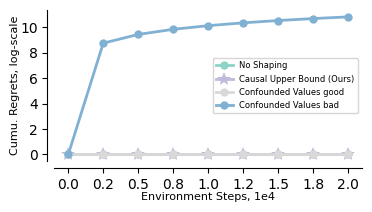

In [4]:
# Draw experiment figures
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from causal_rl.algo.reward_shaping.constants import MAX_EPISODES

env_name = 'causal_gym/RobotWalk-v0'
palette = sns.color_palette('Set3')

METHOD_NAMES = ['No Shaping', 'Causal Upper Bound (Ours)', 'Confounded Values good', 'Confounded Values bad']
COLORS = [palette[0], palette[2], palette[8], palette[4], palette[5]]


print(env_name)
sns.reset_defaults()
stepsize = MAX_EPISODES[env_name]//8
max_y = 0
for i, method in enumerate(METHOD_NAMES):
    full_regret = []
    full_seeds = []
    full_steps = []
    for seed in [5678,]:
        with open(f'regrets/REG-robotwalk-{method}.json', 'r') as f:
            regret = json.load(f)
            regret = (np.array(regret) + 1).tolist() #for better visuals in log scale
            max_y = max(max(np.log(regret)), max_y)
            full_regret += regret[::stepsize-1]
            full_seeds += [seed,]*len(regret[::stepsize-1])
            full_steps += list(range(len(regret)))[::stepsize-1]
    regret = pd.DataFrame(data={'step':full_steps, 'reg':np.log(full_regret), 'seed':full_seeds}).sort_values('step', ascending=True)
    # shift the x-axis a little bit to get the last element
    marker = 'o' if method != 'Causal Upper Bound (Ours)' else '*'
    markersize = 6 if method != 'Causal Upper Bound (Ours)' else 10
    alpha = 1.0 if method != 'Causal Upper Bound (Ours)' else 1.0
    ax = sns.lineplot(data=regret, x='step', y='reg', label=f'{method}', legend='brief', linewidth=2, color=COLORS[i], marker=marker, markersize=markersize, mew=0, alpha=alpha)   


ax.set_xlabel('Environment Steps, 1e'+str(len(str(MAX_EPISODES[env_name])[1:])), fontsize=8, labelpad=0)
ax.set_ylabel('Cumu. Regrets, log-scale', fontsize=8, labelpad=0)

magnitude = 10**int(f'{MAX_EPISODES[env_name]:.1E}'.split('+')[1])
ax.set_xticks(range(0, MAX_EPISODES[env_name]+1, stepsize), labels=[f'{i/magnitude:.1f}' for i in range(0, MAX_EPISODES[env_name]+1, stepsize)], fontsize=12)
ax.set_yticks(range(0, int(np.ceil(max_y))+1, 2), labels=[str(i) for i in np.arange(0, int(np.ceil(max_y))+1, 2)], fontsize=12)
plt.setp(ax.get_legend().get_texts(), fontsize='10') 
# Calculate maximum label length
max_label_length = max(len(label.get_text()) for label in plt.legend().get_texts())
# Adjust font size based on label length
fontsize = 11 - max_label_length * 0.2
plt.legend(fontsize=fontsize)

sns.despine(offset=5)
sns.set_theme(font_scale=8)
plt.tight_layout()
plt.show()

Since this is a an easy example, both no shaping and shaping with the optimal behavioral policy values method can converge 
easily to the optimal policy. Note that the optimal behavioral value is also a valid upper bound of optimal interventional policy value.

Only shaping with the value of the bad behavioral policy cannot converge efficiently. Yet after using our causal bound with data from both the good and the bad policy, the agent can still converge well.